Apache spark JVM(Java Virtual Machine) ortamında çalıştığı için java paketlerini kurmamız gerekiyor.

In [2]:
!apt-get update -qq #java için sanal olan ubuntu ortamını kurar.
!apt-get install -y openjdk-8-jdk-headless -qq #java kodlarını falan inceleyebilmek hataları görmek için.

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u452-ga~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u452-ga~us1-0ubuntu1~22.04) ...
Setting up libxtst6:amd64 (2:1.2.3-1build4) ...
Setting up openjdk-8-jre-headless:amd64 (8u452-ga~us1-0ubu

In [3]:
!pip install -q pyspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" #saprka javanın yolunu bildirir.Çünkü spark başlamadan önce javayı görmelidir.

In [7]:
from pyspark.sql import SparkSession #Sparkın  dataframe apisini kullanabilmek için

from pyspark.sql import SparkSession #Sparkın  dataframe apisini kullanabilmek için

spark = SparkSession.builder \
    .appName("SentimentClassification") \
    .master("local[*]") \
    .getOrCreate() # aynı süreçte birden fazla sessionun oluşup gereksiz kaynak kullanımını engeller.

In [8]:
!pip install -q kagglehub[pandas-datasets]

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mujdatcabuk/eticaret-urun-yorumlari")

print("Path to dataset files:", path)

100%|██████████| 428k/428k [00:00<00:00, 34.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mujdatcabuk/eticaret-urun-yorumlari/versions/4


In [10]:
# --- Dosyayı doğru ayırıcıyla yeniden oku ---
spark_df = (
    spark.read
         .option("delimiter", ";")   # CSV noktalı virgül ile ayrıldığı için. Yanlış bir seçim olursa tüm satır tek sütunmuş gibi okunur.
         .option("header", "true") # ilk satırın sütun adları(header) olduğunu söyler.
         .csv("/root/.cache/kagglehub/datasets/mujdatcabuk/eticaret-urun-yorumlari/versions/4/e-ticaret_urun_yorumlari.csv") #dosyayı okur sonuç olarak bir dataframe föndürür.
)

# Kontrol: şema ve ilk satırlar
spark_df.printSchema()
spark_df.show(10, truncate=60) #60 karakterden sonra ... olarak gelir.

# Etiket dağılımı
spark_df.groupBy("Durum").count().show() #groupBy her etikete göre gruplar.


root
 |-- Metin: string (nullable = true)
 |-- Durum: string (nullable = true)

+------------------------------------------------------------+-----+
|                                                       Metin|Durum|
+------------------------------------------------------------+-----+
|                                       evet anlatıldığı gibi|    1|
|Daha öncede almıştım bu cihazdan ense ve sakal tüketmek i...|    1|
|Ürün gayet başarılı sakal kesmede başlık sayısı biraz dah...|    1|
|Daha öncede aynısını almıştım çok güzel ve kaliteli bir ü...|    1|
|Erkek kuaförüyüm ense ve sıfır sakal traşı için uygun bir...|    1|
|                                    ürün gerçekten çok güzel|    1|
|Ürün beklediğimden güzel çıktı gayet kullanışlı tarklarda...|    1|
|                                 güzel makina tavsiye ederim|    1|
|                   tavsiye edebileceğim çok güzel bir makina|    1|
|ürün geldiğinde şarjı vardı. ilk lullanım öncesi 10 saat ...|    1|
+----------------------

In [13]:
from pyspark.sql import functions as F # PySpark fonksiyonlarını kısaltarak kullanmayı sağlar.

# 0 → negative, 1 → positive, 2 → neutral
label_map = {
    0: "negative",
    1: "positive",
    2: "neutral"
}

spark_df_labeled = (
    spark_df                                    #cast ile modeli besleyecek sayısal hedef oluşturuldu.
        .withColumn("Durum_int", F.col("Durum").cast("int")) #durum satırındaki string ifadeleri int değerlere çevirip durum_int sütununa yazar.Bunu yapmasının nedeni sparkMLlib modelleri kategorik hedefi sayısal ister.
        .withColumn(
            "label",
            F.create_map([F.lit(x) for x in sum(label_map.items(), ())])[F.col("Durum_int")]
        )
        .select("Metin", "Durum_int", "label")  #burada kullanacağım sütunları seçtim, göstermek için durumu da ekleyebilirsin sunum anında.
)

# Kontrol: ilk satırlar ve yeni etiket dağılımı
spark_df_labeled.show(15, truncate=60)
spark_df_labeled.groupBy("label").count().show() #eğitim sırasında durum int kullanacağız , raporlamada label


+------------------------------------------------------------+---------+--------+
|                                                       Metin|Durum_int|   label|
+------------------------------------------------------------+---------+--------+
|                                       evet anlatıldığı gibi|        1|positive|
|Daha öncede almıştım bu cihazdan ense ve sakal tüketmek i...|        1|positive|
|Ürün gayet başarılı sakal kesmede başlık sayısı biraz dah...|        1|positive|
|Daha öncede aynısını almıştım çok güzel ve kaliteli bir ü...|        1|positive|
|Erkek kuaförüyüm ense ve sıfır sakal traşı için uygun bir...|        1|positive|
|                                    ürün gerçekten çok güzel|        1|positive|
|Ürün beklediğimden güzel çıktı gayet kullanışlı tarklarda...|        1|positive|
|                                 güzel makina tavsiye ederim|        1|positive|
|                   tavsiye edebileceğim çok güzel bir makina|        1|positive|
|ürün geldiğinde

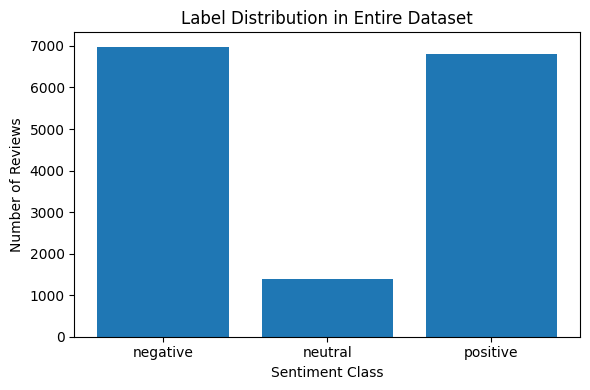

In [ ]:
# === Hücre 1 ===
# Spark → Pandas: yalnızca label ve count verilerini çekiyoruz
counts_pdf = (
    spark_df_labeled
        .groupBy("label") #her etiketi grupla
        .count()
        .orderBy("label") #alfabetik sıraya koy
        .toPandas() #küçük sonuçları sunucuya çek
)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(counts_pdf["label"], counts_pdf["count"]) #x ekseninde etiketler y ekseninde sayıları
plt.title("Label Distribution in Entire Dataset")
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment Class")
plt.tight_layout() #kenar boşluklarını ayarlar.
plt.show()


In [15]:
# --- Eğitim (%80) – Doğrulama (%20) ayrımı ---
train_df, val_df = spark_df_labeled.randomSplit([0.8, 0.2], seed=42)

# Kontrol: kaç kayıt var?
print(f"Train set   : {train_df.count():,}")
print(f"Validation  : {val_df.count():,}")

# Her sette etiket dağılımı
print("\nEğitim kümesi dağılımı:")
train_df.groupBy("label").count().show()

print("Doğrulama kümesi dağılımı:")
val_df.groupBy("label").count().show()


Train set   : 12,188
Validation  : 2,982

Eğitim kümesi dağılımı:
+--------+-----+
|   label|count|
+--------+-----+
|positive| 5466|
| neutral| 1107|
|negative| 5615|
+--------+-----+

Doğrulama kümesi dağılımı:
+--------+-----+
|   label|count|
+--------+-----+
|positive| 1333|
| neutral|  286|
|negative| 1363|
+--------+-----+



In [18]:
from pyspark.ml import Pipeline # birden çok adımı tek bir iş hattına zincirleyerek eğitim-test sırasında hepsini tek komutla çalıştırmaya yarar.
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer #Tokenizer:metin sütununu boşluklardan bölerek token listesine çevirir(metin önişleme).
                                                               #StopWordRemover:Sık kullanılan ancak anlam taşımayan kelimeleri listeden çıkarır(temizlik).
                                                               #HashingTF:Token listesini sabit boyutlu sayısal vektör haline getirir.(özellik çıkarımı(TF))
                                                               #IDF: TF vektörlerine inverse document frequency katsayısı ekleyerek nasir kelimelere daha çok ağırlık verir.
                                                               #StringIndexer:String etiketleri sayısal etiketlere dönüştürür.Labeldeki
                                                               #LogisticRegression: Çoklu sınıflı lojistik regresyon modeli.TF-IDF vektörlerini alıp etiketi tahmin eder.
                                                               #MulticlassClassificationEvaluator:Modelin deoğruluğunu hesaplar.

)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- 1) Aşamalar ---

# 1.1  Etiketi sayısala çevir (“negative”→0, “neutral”→1, “positive”→2)
label_indexer = StringIndexer(
    inputCol="label",
    outputCol="labelIndex",
    handleInvalid="skip"      # olası hatalı etiketleri atla
)

# 1.2  Tokenizasyon
tokenizer = Tokenizer(
    inputCol="Metin",
    outputCol="tokens"
)

# 1.3  Stop-word temizliği (Türkçe + İngilizce)
tr_stop = ["bir", "ve", "veya", "mi", "mı", "de", "da", "çok", "daha",
           "gibi", "ama", "fakat", "ile", "için", "şu", "bu", "o"]
stopper = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered",
    stopWords=StopWordsRemover.loadDefaultStopWords("turkish") + tr_stop
)

# 1.4  Hashing TF . hash değeri için (Spark ▶ MurmurHash3 ) aynı kelimelerin hash değeri aynıdır.
hashingTF = HashingTF (  #her kelimeye bir hash değeri atanır bu değerin numfye göre modu alınır.Ve çıkan değer 0- numf arasında bir kutudur ve oraya yerleştirilir eğer aynı değerde bir atne daha çıkarsa o kutu 2 olur.
    inputCol="filtered",
    outputCol="rawFeatures",
    numFeatures=20_000 #vektör boyutu
  )
"""   +------------------------------------------+------------------------------+
|tokens                                    |rawFeatures                   |
+------------------------------------------+------------------------------+
|[ürün, mükemmel, kalite, ürün]            |(20_000,[1,2,3,6],[2.0,1.0,1.0,1.0])|
|[fiyat, pahalı, ama, kalite, iyi]         |(20_000,[0,2,4,5,9],[1.0,1.0,1.0,1.0,1.0])|
+------------------------------------------+------------------------------+ """


# 1.5  IDF  (TF-IDF vektörleri)
idf = IDF(
    inputCol="rawFeatures",
    outputCol="features"
)
"""IDF(t)=log(N+1)/df(t)+1  N: veri kümesindeki toplam cümle sayısı, df(t) t kelimesinin kaç farklı cümlede görüldüğü.IDF küçük olunca yaygın kelime oluyor.Ağırlık düşüyor.Böylece ayırt edici kelimelere yüksek ağırlık verir.Ve sonra ağırlıkları ile çarpılırlar ."""

# 1.6  Lojistik Regresyon
lr = LogisticRegression(
    labelCol="labelIndex",  #bağımlı değişkenler
    featuresCol="features", #bağımsız değişkenler
    maxIter=20,
    regParam=0.0, #overfittingi engellemek içindir.
    elasticNetParam=0.0
)

# --- 2) Pipeline ---
pipeline = Pipeline(stages=[
    label_indexer,
    tokenizer,
    stopper,
    hashingTF,
    idf,
    lr
])

# --- 3) Eğit ---
model = pipeline.fit(train_df) # öğrenmesi gereken tüm adımları eğitir ve tek bir piplinemodel oluşturur. fit() öğren , transform() uygula tahmin et

# --- 4) Doğrulama ---
preds = model.transform(val_df) #eğitilmiş modeli pipline doğrulama kümesine sokar.

evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex", #gerçek etiketlerin bulunduğu kısım
    predictionCol="prediction", #modelin ürettiği tahmin sütunu
    metricName="accuracy" #hangi scorun hesaplanacağını söyler.Bu totolde ki doğruluk oranı
)
val_accuracy = evaluator.evaluate(preds) #hakem satır satır  gider eğer labelIndex ile prediction eşleşiyorsa doğru sayar ve toplam doğruları tüm satıra böler ve tek bir sonuç döndürür.
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\n--- İlk 10 tahmin ---")
preds.select("labelIndex", "prediction").show(15, truncate=False)

Validation Accuracy: 0.8246

--- İlk 10 tahmin ---
+----------+----------+
|labelIndex|prediction|
+----------+----------+
|0.0       |0.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|1.0       |2.0       |
|1.0       |2.0       |
|1.0       |2.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|0.0       |0.0       |
|1.0       |2.0       |
+----------+----------+
only showing top 15 rows



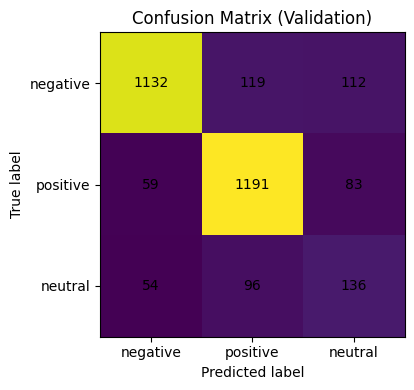

In [ ]:
# === Hücre 2 ===
# 1. Spark pred DF → Pandas (yalnızca gerçek & tahmin kolonları)
y_true_pred = (
    preds.select("labelIndex", "prediction")   # 'preds' model eğitimi hücresinden geliyor
         .toPandas()
)

# 2. Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(
    y_true_pred["labelIndex"],
    y_true_pred["prediction"],
    labels=[0,1,2]   # 0=negative,1=positive,2=neutral (StringIndexer sırasına göre)
)

classes = ["negative", "positive", "neutral"]
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Validation)")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Sayısal değerleri karelerin içine yaz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

#modelin doğruluğu %82.5 ve bu doğruluğun %89unu pozitifler yaparken , %83ünü negatifler sağlarken naturaller %43 ile modelimizin doğruluğunu düşürüyor.Veri dengesini iyileştirip n-gram/lemmatizasyon eklersek neutral performansı da yukarı çekebiliriz.”

In [25]:
from pyspark.ml import PipelineModel
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType


# StringIndexer’ı (stages[0]) atla
inference_model = PipelineModel(stages=model.stages[1:]) #burada ürettiğimiz modeldeki piplinedeki ilk aşamayı çıkarır çünkü label olamdığı için indexer yapmaya gerek yok.

examples = [
    "Ürün beklediğim gibi gelmedi, iade gönderdim.",
    "Kargo çok hızlıydı, paketleme harikaydı. Teşekkürler!",
    "Fiyat–performans olarak idare eder, ne iyi ne kötü.",
    "Kesinlikle tavsiye etmiyorum; kalitesi sıfır.",
    "Harika! Beklentimin üstünde çıktı.",
    "Ürün kaliteli ancak pahalı."
]

test_df = spark.createDataFrame([Row(Metin=x) for x in examples]) #metin sütunlu dataframe oluşturur.

pred_df = inference_model.transform(test_df)  #piplineyi test verisine uygular.Transform hiçbir şey öğretmez sadece uygular.

# LogisticRegressionModel’ın içindeki etiket sırası:
label_list = model.stages[0].labels #orjinal etiket verilerini döndürür.
to_label   = udf(lambda idx: label_list[int(idx)], StringType())  #Spark DataFrame’deki her satır için Python fonksiyonunu vektörize ederek çağırır; 0.0→“negative”, 1.0→“positive”…

result_df = (
    pred_df
      .withColumn("predicted_label", to_label("prediction"))
      .select("Metin", "predicted_label", "probability")
)

result_df.show(truncate=False)


+-----------------------------------------------------+---------------+----------------------------------------------------------------+
|Metin                                                |predicted_label|probability                                                     |
+-----------------------------------------------------+---------------+----------------------------------------------------------------+
|Ürün beklediğim gibi gelmedi, iade gönderdim.        |negative       |[0.9999458431522829,3.1727491903631404E-5,2.2429355813470913E-5]|
|Kargo çok hızlıydı, paketleme harikaydı. Teşekkürler!|positive       |[0.0024771047008174583,0.9937477584932632,0.003775136805919222] |
|Fiyat–performans olarak idare eder, ne iyi ne kötü.  |negative       |[0.9433514520607259,7.326700025319261E-6,0.0566412212392488]    |
|Kesinlikle tavsiye etmiyorum; kalitesi sıfır.        |negative       |[0.9999461295508838,5.3483802537338786E-5,3.8664657883639687E-7]|
|Harika! Beklentimin üstünde çıktı.      